## Поведение пользователей мобильного приложения.

**Оглавление:**  

#### [Шаг 1. Общая информация](#step1)
#### [Шаг 2. Подготовка данных](#step2)
#### [Шаг 3. Анализ данных логов](#step3)
#### [Шаг 4. Анализ воронки событий](#step4)
#### [Шаг 5. Анализ результатов эксперимента](#step5)
#### [Шаг 6. Общий вывод](#step6)

### Шаг 1. Общая информация <a name="step1"></a>

Изучим общую информацию.

In [2]:
import pandas as pd
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth

logs_exp = pd.read_csv('logs_exp.csv', sep="\t")

In [3]:
logs_exp.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


#### Вывод  
  
В данных более 200тыс. строк. Пропущенных значений нет, но имеются несоответствия типов данных. Предобработаем данные в следующем шаге.

### Шаг 2. Подготовка данных <a name="step2"></a>

In [5]:
#переименуем столбцы
logs_exp.columns = ['events', 'user_id', 'event_time', 'group']

In [6]:
#данные в колонке с датой приведем к соответствующему типу
logs_exp['event_time'] = pd.to_datetime(logs_exp['event_time'], unit ='s')

#выделим дату в отдельный столбец
logs_exp['event_date'] = pd.to_datetime(logs_exp['event_time'].dt.date)

logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   events      244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   group       244126 non-null  int64         
 4   event_date  244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [7]:
logs_exp.head(3)

,events,user_id,event_time,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25


In [8]:
#заменим наименования событий, а также обозначим группы
logs_exp['events'] = logs_exp['events'].replace({'MainScreenAppear':'Main Screen', 
                                                 'PaymentScreenSuccessful':'Payment Successful', 
                                                 'OffersScreenAppear':'Offers Screen', 'CartScreenAppear':'Cart Screen'})
logs_exp['group'] = logs_exp['group'].replace({246:'A1', 247:'A2', 248:'B'})
logs_exp.head(3)

,events,user_id,event_time,group,event_date
0,Main Screen,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,Main Screen,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,Payment Successful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25


In [9]:
#проверим наличие дубликатов в данных

display(logs_exp.duplicated().sum())

#Удалим дубликаты
logs_exp = logs_exp.drop_duplicates().reset_index(drop=True)

display(logs_exp.duplicated().sum())

413

0

#### Вывод  
На этом шаге мы предобработали данные. Для нашего удобства переименовали столбцы, заменили наименования событий, а также обозначили группы. Значения в колонке даты и времени привели к типу *datetime*. В отдельный столбец выделили дату. В конце шага проверили наличие дубликатов. Обнаружили 413 штук. Их можно удалить, т.к. это менее 1% наших данных, что мы и сделали.

### Шаг 3. Анализ данных логов <a name="step3"></a>

In [10]:
#Найдем сколько всего событий в логе
count_events = logs_exp['events'].count()
print('Всего событий в логе: ', count_events)
print(' ')

#Найдем сколько пользователей в логе
count_users = logs_exp['user_id'].nunique()
print('Всего пользователей в логе: ', count_users)
print(' ')

#Найдем сколько в среднем событий приходится на пользователя
avg_events = count_events/count_users
avg_events
print('На каждого пользователя приходится в среднем :', int(avg_events), 'события')
print(' ')

median_users = logs_exp.groupby('user_id').agg({'events':'count'}).reset_index()
print('Медианное значение количества событий на пользователя :', int(median_users['events'].median()), 'событий')
print(' ')

Всего событий в логе:  243713
 
Всего пользователей в логе:  7551
 
На каждого пользователя приходится в среднем : 32 события
 
Медианное значение количества событий на пользователя : 20 событий
 


Данные за: 14 дней
 
Минимальная дата: 2019-07-25 00:00:00
Максимальная дата: 2019-08-07 00:00:00


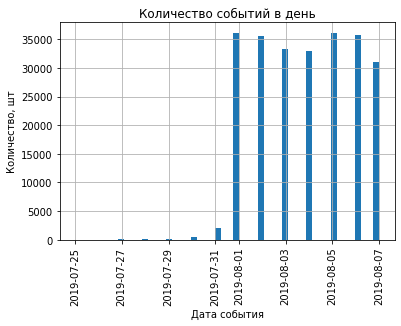

In [11]:
#Найдем период данных, максимальную и минимальную даты
period = logs_exp.pivot_table(index = 'event_date', values = 'events', aggfunc = 'count')
print('Данные за:', len(period), 'дней')
print(' ')

min_date = logs_exp['event_date'].min()
max_date = logs_exp['event_date'].max()
print("Минимальная дата:", min_date)
print("Максимальная дата:", max_date)
#Построим гистограмму по дате и времени
logs_exp['event_date'].hist(bins = 50)
plt.xticks(rotation=90)
plt.title("Количество событий в день", fontsize=12)
plt.xlabel("Дата события")
plt.ylabel("Количество, шт")
plt.show()

In [12]:
#отбросим старые данные
event_logs = logs_exp[logs_exp['event_date'] > '2019-07-31'].reset_index(drop=True)

cc_events = event_logs['events'].count()
print('Осталось событий в логе: ', cc_events)
print('Удалили: ', count_events - cc_events)
print(' ')

cc_users = event_logs['user_id'].nunique()
print('Осталось пользователей в логе: ', cc_users)
print('Удалили: ', count_users - cc_users)
print(' ')

avg_events_cor = cc_events/cc_users

print('На каждого пользователя приходится в среднем :', int(avg_events_cor), 'событие')
print(' ')

median_users_cor = event_logs.groupby('user_id').agg({'events':'count'}).reset_index()
print('Медианное значение количества событий на пользователя :', int(median_users_cor['events'].median()), 'событий')
print(' ')

Осталось событий в логе:  240887
Удалили:  2826
 
Осталось пользователей в логе:  7534
Удалили:  17
 
На каждого пользователя приходится в среднем : 31 событие
 
Медианное значение количества событий на пользователя : 19 событий
 


In [13]:
#Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.
checking_groups = (event_logs.
              pivot_table(index = 'events', 
                          columns = 'group', 
                          values = 'user_id', 
                          aggfunc = 'nunique')
              .reset_index())
checking_groups.columns = ['events', 'A1', 'A2', 'B']
checking_groups

,events,A1,A2,B
0,Cart Screen,1266,1238,1230
1,Main Screen,2450,2476,2493
2,Offers Screen,1542,1520,1531
3,Payment Successful,1200,1158,1181
4,Tutorial,278,283,279


#### Вывод  
В наших данных было 243713 лога и 7551 пользователь. Мы определили, что у нас имеются данные за 14 дней. Построили гистограмму по дате и увидели неполноту данных: в первую неделю событий было очень мало и только с 01-08-2019 количество событий резко увеличилось. Для дальнейшей работы, мы определили новый период - 7 дней с 01-08-2019 по 07-08-2019. В нашем новом периоде осталось 241298 логов и 7534 пользователя из всех трёх групп.

### Шаг 4. Анализ воронки событий <a name="step4"></a>

In [14]:
#определим какие события есть в логах и отсортируем их по частоте.
users_events = (event_logs
                .groupby('events')
                .agg({'user_id': 'count'})
                .sort_values(by = 'user_id', ascending = False)
                .reset_index())
users_events

,events,user_id
0,Main Screen,117328
1,Offers Screen,46333
2,Cart Screen,42303
3,Payment Successful,33918
4,Tutorial,1005


In [15]:
# Посчитаем, сколько пользователей совершали события и найдем долю пользователей, которые хоть раз совершали событие.

uniq_users_event = (event_logs.groupby('events')
                    .agg({'user_id': 'nunique'})
                    .sort_values(by = 'user_id', ascending = False)
                    .reset_index())

uniq_users_event['part, %'] = (uniq_users_event['user_id']/cc_users*100).round(1)

uniq_users_event

,events,user_id,"part, %"
0,Main Screen,7419,98.5
1,Offers Screen,4593,61.0
2,Cart Screen,3734,49.6
3,Payment Successful,3539,47.0
4,Tutorial,840,11.1


Основываясь на названиях событий и количестве уникальных пользователей, совершивших это событие, предположим, что события происходят в следующем порядке: **Main Screen -> Offers Screen -> Cart Screen -> Payment Successful**. У нас остается одно событие **Tutorial**, которое может произойти в любом порядке: пользователь может в любой момент обратиться за справкой в приложении - при входе в приложение, при оформлении заказа или оплаты. При этом мы видим, что всего 11% пользователей используют это событие, поэтому **Tutorial** мы можем не учитывать при дальнейшем расчёте воронки. Стоит обратить внимание на долю пользователей зашедших на главный экран: 98,5%, вместо ожидаемых 100%. Если учесть, что в мобильном приложении невозможно пропустить главную страницу, то можем предположить почему это произошло: при записи лога на сервер произошла проблема с соединением и как только сеть появилась, записалось текущее событие и уже после подгрузились предыдущие, а также с определением нашего нового периода данных.

In [16]:
#отбросим лишнее событие
new_event_logs = event_logs.query('events != "Tutorial"').reset_index(drop=True)

#Расчитаем воронку событий и определим какая доля пользователей проходит на следующий шаг воронки

funnel = (new_event_logs.groupby('events')
                    .agg({'user_id': 'nunique'})
                    .sort_values(by = 'user_id', ascending = False)
                    .reset_index())

funnel.loc[0,'step_conversion'] = (funnel.loc[0,'user_id']/cc_users*100).round(1)
for i in range(3):
    funnel.loc[(i+1),'step_conversion'] = (funnel.loc[(i+1), 'user_id']/funnel.loc[i, 'user_id']*100).round(1)
funnel['full_conversion'] = (funnel['user_id']/cc_users*100).round(1)
funnel

,events,user_id,step_conversion,full_conversion
0,Main Screen,7419,98.5,98.5
1,Offers Screen,4593,61.9,61.0
2,Cart Screen,3734,81.3,49.6
3,Payment Successful,3539,94.8,47.0


In [17]:
from plotly import graph_objects as go
fig = go.Figure(go.Funnel(
    y = funnel['events'], x = funnel['user_id'],
    textposition = "inside", textinfo = "value+percent initial", 
    opacity = 0.55, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"]},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}}))
fig.update_layout(title="Воронка событий (кол-во пользователей на каждом шаге)")
fig.show()

ModuleNotFoundError: No module named 'plotly'

In [18]:
#На каком шаге теряете больше всего пользователей?
funnel.loc[0,'users_lost'] = (cc_users - funnel.loc[0,'user_id'])
for i in range(3):
    funnel.loc[(i+1),'users_lost'] = (funnel.loc[i, 'user_id'] - funnel.loc[(i+1), 'user_id'])
funnel

,events,user_id,step_conversion,full_conversion,users_lost
0,Main Screen,7419,98.5,98.5,115.0
1,Offers Screen,4593,61.9,61.0,2826.0
2,Cart Screen,3734,81.3,49.6,859.0
3,Payment Successful,3539,94.8,47.0,195.0


По полученной таблице видим, что большинство пользователей теряется при переходе с **Main Screen -> Offers Screen** 

In [19]:
#Какая доля пользователей доходит от первого события до оплаты?

the_end = (funnel.loc[3, 'user_id']/funnel.loc[0, 'user_id']*100).round(1)
print( )
print(the_end, '% пользователей доходит от первого события до оплаты.')


47.7 % пользователей доходит от первого события до оплаты.


#### Вывод  
  
На шаге анализа воронки событий мы:  
 1. Определили, какие события есть в логах, как часто они встречаются
 2. Посчитали, сколько пользователей совершали каждое из этих событий и нашли долю пользователей, которые хоть раз совершали событие
 3. Предположили порядок событий и отсекли выбивыющееся из порядка событие **Tutorial**
 4. По воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки
 5. Определили, что на шаге **Main Screen -> Offers Screen**  теряется больше всего пользователей
 6. Определили, что 47,7% пользователей доходит от первого события до оплаты.

### Шаг 5. Анализ результатов эксперимента <a name="step5"></a>

In [20]:
#Найдем сколько пользователей в каждой экспериментальной группе
users_group = (new_event_logs.
               pivot_table(columns = 'group', 
                           values = 'user_id', 
                           aggfunc = 'nunique')
               .reset_index(drop = True))
users_group.drop([0], inplace=True)
users_group.columns = ['A1', 'A2', 'B']
users_group

,A1,A2,B
1,2483,2512,2535


In [21]:
#построим воронку событий для каждой группы
test_group = (new_event_logs.
              pivot_table(index = 'events', 
                          columns = 'group', 
                          values = 'user_id', 
                          aggfunc = 'nunique')
              .reset_index())

test_group.columns = ['events', 'A1', 'A2', 'B']
test_group = test_group.sort_values('A1', ascending = False).reset_index(drop = True)
test_group

,events,A1,A2,B
0,Main Screen,2450,2476,2493
1,Offers Screen,1542,1520,1531
2,Cart Screen,1266,1238,1230
3,Payment Successful,1200,1158,1181


У нас есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Необходимо проверить находят ли статистические критерии разницу между выборками A1 и A2. Для этого воспользуемся Z-критерием:

$$Z = \frac{(P_1 - P_2) - (\pi_1-\pi_2)}{\sqrt{P(1-P)(1/n_1 + 1/n_2)}}$$  
В формуле $n_1$ и $n_2$ — размеры двух сравниваемых выборок; $P_1$, $P_2$ — пропорции, наблюдаемые в выборках; $P$ — пропорция в выборке, скомбинированной из двух наблюдаемых; $\pi_1$, $\pi_2$ — настоящие пропорции в сравниваемых генеральных совокупностях. При верной нулевой гипотезе выражение $(\pi_1 - \pi_2)$ в числителе будет равно нулю, и критерий рассчитывается только по выборочным данным.

In [22]:
#Проверим, находят ли статистические критерии разницу между выборками A1 и A2

alpha = 0.05 # критический уровень статистической значимости

successes = np.array([test_group.loc[3,'A1'], test_group.loc[3,'A2']])#пользователи, дошедшие до оплаты 
trials = np.array([users_group.loc[1,'A1'], users_group.loc[1,'A2']])#всего пользователей в группах

# пропорция успехов в первой группе и во второй группе:
p1 = successes[0]/trials[0]
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций
difference = p1 - p2

# считаем статистику 
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# зададим стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

Проверим гипотезу:
  - Имеется ли статистически значимое различие между долями двух групп А1 и А2;

Сформулируем нулевую гипотезу H₀: Различия между долями нет, они равны. Поскольку H₀ всегда формулируется так, чтобы использовать знак равенства. Исходя из H₀ сформулируем альтернативную гипотезу H₁: Различия между долями есть, они разные.


In [23]:
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)
print()

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  0.11446627829276612

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Поскольку мы провели одно сравнение, то значение уровня статистической значимости $\alpha = 0,05$ нам достаточно.
Далее нам необходимо провести проверку различия долей между другими группами, т.е нам нужно провести несколько сравнений. Мы должны учесть увеличение вероятности ошибок первого и второго родов. Воспользуемся методом Шидака, тогда скорректированное значение требуемого уровня значимости рассчитывается по формуле: $$\alpha = 1 - (1-\alpha)^1/m$$, где $m$ - количество сравнений. В нашем случае оно равно 16, т.к: у нас 4 события и 4 пары групп (*А1:А2, А1:В, А2:В, А1+А2:В*)

In [24]:
#cкорректированное значение уровня значимости

sh_alpha = 1 - (1 - alpha)**(1/16)
sh_alpha

0.0032006977101884937

In [25]:
#добавим в данные группу A1+A2
test_group['A1+A2'] = test_group['A1'] + test_group['A2']
users_group['A1+A2'] = users_group['A1'] + users_group['A2']

In [26]:
#составим фукцию проверки статистической достоверности для каждого события с помощью Z-критерия

def proverka_gipotez(X,Y):
    for i in range(4):
        print("Проверим статистическую достоверность по событию:", test_group.loc[i,'events'])
        successes = np.array([test_group.loc[i,X], test_group.loc[i,Y]])
        trials = np.array([users_group.loc[1,X], users_group.loc[1,Y]])
        p1 = successes[0]/trials[0]
        p2 = successes[1]/trials[1]
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
        difference = p1 - p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('p-значение: ', p_value)
        if (p_value < sh_alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print()

Теперь мы проверяем гипотезу каждой пары групп:  
- Имеется ли статистически значимое различие между долями;

Сформулируем нулевую гипотезу H₀: Различия между долями нет, они равны. Поскольку H₀ всегда формулируется так, чтобы использовать знак равенства. Исходя из H₀ сформулируем альтернативную гипотезу H₁: Различия между долями есть, они разные.

In [27]:
#применим функцию к группам

group_list = pd.DataFrame(data={'col1': ["A1", "A1", "A2", "A1+A2"], 'col2': ["A2", "B", "B", "B"]})
for i in range(4):
    print("Сравним результат группы:", group_list.loc[i,'col1'], "с группой:", group_list.loc[i,'col2'])
    proverka_gipotez(group_list.loc[i,'col1'], group_list.loc[i,'col2'])
    print("_______________________________________________________________")
    print()

Сравним результат группы: A1 с группой: A2
Проверим статистическую достоверность по событию: Main Screen
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверим статистическую достоверность по событию: Offers Screen
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверим статистическую достоверность по событию: Cart Screen
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверим статистическую достоверность по событию: Payment Successful
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

_______________________________________________________________

Сравним результат группы: A1 с группой: B
Проверим статистическую достоверность по событию: Main Screen
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет основ

#### Вывод  
На этом шаге мы:  
- определили сколько пользователей в каждой экспериментальной группе
- проверили, находят ли статистические критерии разницу между выборками А1 и А2.
- провели проверку для всех событий и всех групп
- определили уровень статистической значимости методом Шидака
- посчитали количество проверок - их оказалось 16
- при сравнении долей групп по каждому событию, нулевая гипотеза ни разу не была отвергнута. Это говорит о том, что существенных различии между группами нет. 

### Шаг 6. Общий вывод <a name="step6"></a>

В ходе работы мы разобрались, как ведут себя пользователи нашего мобильного приложения. Изучили воронку продаж и узнали, как пользователи доходят до покупки. Определили сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно шагах.  
После этого мы исследовали результаты A/A/B-эксперимента. Наши дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Была договоренность принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

В нашем распоряжении имелись логи с сервера нашего мобильного приложения. В данных было 244126 лога и 7551 пользователь. Пропущенных значений не было, но имелись несоответствия типов данных и дубликаты - 413 штук. В шаге предобработки данных мы привели данные к нужному типу и удалили дубликаты. После этого в данных осталось 243713 лога и 7551 пользователь. Для нашего удобства мы переименовали столбцы, заменили наименования событий и обозначили группы - 2 контрольные со старыми шрифтами А1 и А2 и экспериментальная - В. Мы определили, что у нас имеются данные за 14 дней. Построили гистограмму по дате и увидели неполноту данных: в первую неделю событий было очень мало и только с 01-08-2019 количество событий резко увеличилось. Для дальнейшей работы, мы определили новый период - 7 дней с 01-08-2019 по 07-08-2019. В нашем новом периоде осталось 241298 логов и 7534 пользователя из всех трёх групп.    


В шаге анализа воронки событий мы определили, какие события есть в логах, как часто они встречаются и посчитали, сколько пользователей совершали каждое из этих событий. Нашли долю пользователей, хоть раз совершивших событие. Основываясь на названиях событий и количестве уникальных пользователей, совершивших это событие, мы предположили, что события происходят в следующем порядке: **Main Screen -> Offers Screen -> Cart Screen -> Payment Successful**. У нас осталось одно событие **Tutorial**, которое могло произойти в любом порядке: пользователь может в любой момент обратиться за справкой в приложении - при входе в приложение, при оформлении заказа или оплаты. При этом мы увидели, что всего 11% пользователей используют это событие, поэтому **Tutorial** мы отсекли и не стали учитывать при дальнейшем расчёте воронки. Далее по воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки: с шага **Main Screen -> Offers Screen** переходят 62% пользователей, с шага **Offers Screen -> Cart Screen** - 81%, а с шага **Cart Screen -> Payment Successful** 95% пользователей. При этом всего 47,7% пользователей доходит от первого события до оплаты и большинство пользователей теряется при переходе с **Main Screen -> Offers Screen**.  

На шаге анализа эксперимента мы определили сколько пользователей в каждой экспериментальной группе: в группе А1 - 2483 пользователей, в А2 - 2512, в группе В - 2535. У нас были 2 контрольные группы для А/А-эксперимента - А1 и А2, чтобы проверить корректность всех механизмов и расчётов. Мы провели проверку, находят ли статистические критерии разницу между выборками групп А1 и А2. Для этого воспользовались Z-критерием. По результатам проверки статистической гипотезы о равенстве долей двух групп, можно сказать что различия нет. Поскольку мы проводили одно сравнение, то значения уровня статистической значимости $\alpha=0,05$ нам было достаточно. Далее мы провели проверку различия долей между другими группами, т.е несколько сравнений, а точнее 4 группы по 4 события - 16 сравнений. Мы учли увеличение вероятности ошибок первого и второго родов, поэтому для корректировки уровня значимости воспользовались методом Шидака. Мы получили скорректированное значение уровня значимости: `sh_alpha = 0.0032`. По результатам проверки статистических гипотез, можно сказать, что различий между каждой пары групп нет для каждого события.  
Поскольку среди наших пар групп присутствовала экспериментальная, мы провели сравнения с каждой из контрольных групп в отдельности. Результаты не отличаются от результатов с объединённой контрольной группой. Это говорит о том, что измененный нашими дизайнерами шрифт в приложении не повлиял на поведение пользователей. Менеджеры могут выдохнуть и принять новое изменение.